In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cd /content/drive/MyDrive/00-Scholar/05-wav2vec2gpt/

/content/drive/MyDrive/00-Scholar/05-wav2vec2gpt


In [ ]:
!pip install datasets wandb transformers rouge_score evaluate rouge_metric jiwer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import os
import re
import _pickle as cPickle
import gc
import random
from tqdm import tqdm
import numpy as np
import torch

from datasets import load_dataset, load_metric
from evaluate import load
from rouge_metric import PyRouge


import math
from itertools import groupby

import wandb


DEVICES=['0',]
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = ','.join(DEVICES)
# os.environ["WANDB_DISABLED"] = "true"
os.environ["HF_DATASETS_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

data_dir = './data/'
# cache_dir = "/data4/yoomcache"
cache_dir = "./caches/"
model_cache_dir = os.path.join(cache_dir, 'huggingfaces')
data_cache_dir = os.path.join(cache_dir, 'datasets')
checkpoint_dir = os.path.join(cache_dir, 'checkpoint')

seed = 0
random.seed(0)
np.random.seed(seed)
torch.manual_seed(seed)

import IPython
import seaborn as sns
sns.set(rc = {'figure.figsize':(16,9)})



wandb.init(project="testing-wav2vec2gpt-221123", entity="yoom618") # 2f747faa5c3ba7aa67c3aa9a68f060bf273d26ba
torch.cuda.empty_cache()

ERROR:wandb.jupyter:Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: yoom618. Use `wandb login --relogin` to force relogin


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive/00-Scholar/05-wav2vec2gpt/src')

from wav2vec2GPTwCTC import *
from configuration_wav2vec2gpt import Wav2Vec2GPTConfig

from transformers import Wav2Vec2FeatureExtractor, GPT2Model
from transformers import GPT2Tokenizer, AddedToken
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

In [ ]:
# wav2vec_pretrained = "facebook/wav2vec2-base"
wav2vec_pretrained = "facebook/wav2vec2-base-960h"
gpt_pretrained = "gpt2"

# Should aware that pad_token_id is used to compute CTC loss, 
# so pad_token configuration for both tokenizer and model should be the same
args = {
    
    'pad_token': "<|endoftext|>", 'pad_token_id': 50256,  # 'Ġ' ... 220,
    'unk_token': "<|endoftext|>", 'unk_token_id': 50256,
    'bos_token': "<|endoftext|>", 'bos_token_id': 50256,
    'eos_token': "<|endoftext|>", 'eos_token_id': 50256,
    'ctc_loss_reduction': 'mean',
    
    
    # Wav2Vec
    'hidden_dropout': 0.0,
    'activation_dropout': 0.0,
    'attention_dropout': 0.0,
    'feat_proj_dropout': 0.0,
    'feat_quantizer_dropout': 0.0,
    'final_dropout': 0.2,
    'layerdrop': 0.0,
    # GPT
    'resid_pdrop': 0.0,
    'embd_pdrop': 0.0,
    'attn_pdrop': 0.0,
    
    
    
    'select_random': True,
    'loss_ver': 'ctc-ce',  # 'ctc-ce', 'ce-ctc', 'ctc', 'ce'
    
    
    'add_adapter': True,
    'num_adapter_layers': 3,
    'output_hidden_size': [128, 256, 256, 256],
    'adapter_kernel_size': [4, 3, 3, 3, 3], 
    'adapter_stride':      [2, 2, 2, 1, 1],
    'adapter_padding':     [4, 0, 0, 0, 0],
    'adapter_bias': False,
    
    
    'nhead': 8,
    'dim_feedforward': 2048,
    'topk_size': 48,
    'prev_window': None, 
    'post_window': None,
    
    
}

BATCH_SIZE = 32
LEARNING_RATE = 0.001

config = Wav2Vec2GPTConfig(**args)

In [ ]:
feature_extractor = Wav2Vec2FeatureExtractor.from_pretrained(wav2vec_pretrained, 
                                                             cache_dir=model_cache_dir,
                                                             **args)

tokenizer = GPT2Tokenizer.from_pretrained(gpt_pretrained,
                                          cache_dir=model_cache_dir,
                                          **args)

## Dataset

### Data Loading

In [ ]:
data_fname = 'dataset-vctk-16k.pkl'
# data_fname = 'train-clean-100.pkl'
# data_fname = 'dev-clean.pkl'

dataset_ratio = 1.0
#########################################################

with open(os.path.join(data_dir, data_fname), 'rb') as f:
    gc.disable()
    dataset = cPickle.load(f)
    gc.enable()
print('entire dataset length: {}'.format(len(dataset['text'])))


dataset_size = int(len(dataset['text']) * dataset_ratio)
for k in dataset.keys():
    if k == 'sample_rate': continue
    del dataset[k][dataset_size:]
print('dataset length: {}'.format(dataset_size))


min_audio_length, max_audio_length = 1e6, 0
for arr in dataset['audio_array']:
    if len(arr) > max_audio_length:
        max_audio_length = len(arr)
    if len(arr) < min_audio_length:
        min_audio_length = len(arr)
print('maximum audio length: {} ({} sec)'.format(max_audio_length, 
                                                 max_audio_length / dataset['sample_rate']))
print('minimum audio length: {} ({} sec)'.format(min_audio_length, 
                                                 min_audio_length / dataset['sample_rate']))

entire dataset length: 44070
dataset length: 44070
maximum audio length: 308533 (19.2833125 sec)
minimum audio length: 9643 (0.6026875 sec)


### Data Example

In [ ]:
idx = 11
print('text example: {}'.format(dataset['text'][idx]))
IPython.display.Audio(dataset['audio_array'][idx], rate=16000)

text example: People look, but no one ever finds it.


### Audio Preprocessing w/ `Wav2Vec2FeatureExtractor`

In [ ]:
for idx in tqdm(range(dataset_size)):
    dataset['audio_array'][idx] = feature_extractor(dataset['audio_array'][idx], 
                                                    sampling_rate=dataset['sample_rate'],
                                                    return_tensors="pt",
                                                    padding='max_length',
                                                    max_length=max_audio_length,
                                                    ).input_values[0]

100%|██████████| 44070/44070 [01:44<00:00, 420.92it/s]


### Text Prepressing and Tokenizing w/ `GPT2Tokenizer`

In [ ]:
_RE_REPLACE_PARENTHESIS = (r'[(){}_\[\]]', '')
_RE_REPLACE_QUESTIONMARK = ('\s\?', '?')
_RE_REPLACE_EXCLAMATIONMARK = ('\s\!', '!')
_RE_REPLACE_DOT = ('\s\.', '.')
_RE_COMBINE_WHITESPACE = (r'\s+', ' ')

re_list = [
    _RE_REPLACE_PARENTHESIS,
    _RE_COMBINE_WHITESPACE, 
    _RE_REPLACE_QUESTIONMARK,
    _RE_REPLACE_EXCLAMATIONMARK,
    _RE_REPLACE_DOT,
]

dataset['retext'] = list()

for txt in dataset['text']:
    retxt = txt
    retxt = retxt.lstrip(' .,?!')
    if retxt[:-1] in ['"', "'"]:
        retxt.strip('\"\'')    
    for pattern, repl in re_list:
        retxt = re.sub(pattern, repl, retxt).strip()
    
    dataset['retext'].append(retxt)
    

In [ ]:
dataset['text'] = tokenizer(dataset['retext'],
                            return_tensors="pt",
                            padding='longest'  # VCTK: 42, libritts: 92
                            )

print(dataset['text']['attention_mask'].shape)

torch.Size([44070, 42])


### Generate Custom Dataset

In [ ]:
split_ratio = (0.8, 0.9)
indices = np.arange(dataset_size)
np.random.shuffle(indices)

# train_idx = indices[:int(dataset_size * split_ratio[0])]
train_idx = indices[:dataset_size]
val_idx = indices[int(dataset_size * split_ratio[0]):int(dataset_size * split_ratio[1])]
test_idx = indices[int(dataset_size * split_ratio[1]):]

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, input_values, tokenized_output, indices):
        self.input_values = input_values
        self.tokenized_output = tokenized_output
        self.indices = indices

    def __getitem__(self, idx):
        item = dict()
        item['input_values'] = self.input_values[self.indices[idx]]
        item['labels'] = self.tokenized_output['input_ids'][self.indices[idx]]
        item['output_attention_mask'] = self.tokenized_output['attention_mask'][self.indices[idx]]
        return item

    def __len__(self):
        return len(self.indices)

    

train_dataset = CustomDataset(dataset['audio_array'], dataset['text'], train_idx)
val_dataset = CustomDataset(dataset['audio_array'], dataset['text'], val_idx)
# val_dataset = CustomDataset(dataset['audio_array'], dataset['text'], train_idx[:dataset_size // 10])
test_dataset = CustomDataset(dataset['audio_array'], dataset['text'], test_idx)

In [ ]:
model = Wav2Vec2GPTModel(config=config)

model.wav2vec2 = Wav2Vec2Model2.from_pretrained(wav2vec_pretrained, cache_dir=model_cache_dir, config=config)
transformer = GPT2Model.from_pretrained(gpt_pretrained, cache_dir=model_cache_dir, config=config)
model.lm_head.weight = transformer.wte.weight

if hasattr(model.compressor, 'bias'):
    # model.compressor.bias = nn.Parameter(transformer.wte.weight[config.pad_token_id])
    model.compressor.bias = nn.Parameter(torch.zeros_like(model.compressor.bias))
    model.compressor.bias.requires_grad = False


model.freeze_feature_extractor()
# model.freeze_wav2vec_adapter()
# model.freeze_compressor()
model.freeze_lm_head()

if len(DEVICES) > 1:
    model = nn.DataParallel(model)

Some weights of the model checkpoint at facebook/wav2vec2-base-960h were not used when initializing Wav2Vec2Model2: ['wav2vec2.encoder.layers.7.attention.v_proj.weight', 'wav2vec2.encoder.layers.9.layer_norm.weight', 'wav2vec2.encoder.layers.3.feed_forward.output_dense.weight', 'wav2vec2.encoder.layers.8.attention.k_proj.bias', 'wav2vec2.encoder.layers.0.attention.v_proj.bias', 'wav2vec2.encoder.layers.8.feed_forward.output_dense.weight', 'wav2vec2.encoder.layers.7.final_layer_norm.weight', 'wav2vec2.encoder.layers.8.attention.k_proj.weight', 'wav2vec2.encoder.layers.6.final_layer_norm.weight', 'wav2vec2.encoder.layers.6.layer_norm.bias', 'wav2vec2.encoder.layers.0.attention.q_proj.weight', 'wav2vec2.encoder.layers.2.feed_forward.output_dense.weight', 'wav2vec2.encoder.layers.5.attention.v_proj.weight', 'wav2vec2.encoder.layers.5.attention.k_proj.bias', 'wav2vec2.encoder.layers.1.final_layer_norm.weight', 'wav2vec2.encoder.layers.6.attention.out_proj.weight', 'wav2vec2.encoder.layers.9

In [ ]:
print(model)

Wav2Vec2GPTModel(
  (wav2vec2): Wav2Vec2Model2(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2GroupNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,), bias=False)
          (activation): GELUActivation()
          (layer_norm): GroupNorm(512, 512, eps=1e-05, affine=True)
        )
        (1): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (2): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (3): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=False)
          (activation): GELUActivation()
        )
        (4): Wav2Vec2NoLayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,), bias=Fal

In [ ]:
###### load rouge for validation
# rouge = load_metric("rouge")  # pip install rouge
rouge = PyRouge()  # pip install rouge-metric
wer = load("wer")  # pip install jiwer

def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions.argmax(axis=-1)
    
    ### only distinct ones
    pred_ids = [[key for key, _group in groupby(i)] for i in pred_ids]

    ### all unnecessary tokens are removed
    label_str = tokenizer.batch_decode(labels_ids, skip_special_tokens=True)
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

    # rouge_output = rouge.compute(predictions=pred_str, references=label_str, 
    #                                rouge_types=["rouge2"])['rouge2'].mid
    wer_score = wer.compute(predictions=pred_str, references=label_str)
    rouge_score = rouge.evaluate(hypotheses=pred_str, 
                                 multi_references=[[ref] for ref in label_str])['rouge-2']
    
    return {
        "wer_score": round(wer_score, 4),
        # "rouge2_precision": round(rouge_output.precision, 4),
        # "rouge2_recall": round(rouge_output.recall, 4),
        # "rouge2_fmeasure": round(rouge_output.fmeasure, 4),
        "rouge2_precision": round(rouge_score['p'], 4),
        "rouge2_recall": round(rouge_score['r'], 4),
        "rouge2_fmeasure": round(rouge_score['f'], 4),
    }

In [ ]:
### set training arguments - these params are not really tuned, feel free to change ###

steps_per_epoch = math.ceil(len(train_dataset) / BATCH_SIZE / len(DEVICES))

training_args = Seq2SeqTrainingArguments(
    per_device_train_batch_size=BATCH_SIZE,
    per_device_eval_batch_size=BATCH_SIZE,
    learning_rate=LEARNING_RATE, 
    weight_decay=0.0, adam_beta1=0.9, adam_beta2=0.999, adam_epsilon=1e-08, max_grad_norm=1.0,
    num_train_epochs=50,
    max_steps=-1,
    lr_scheduler_type="cosine", 
    
    logging_strategy='steps',
    logging_steps=(steps_per_epoch // 10),
    evaluation_strategy='steps',
    eval_steps=(steps_per_epoch),
    warmup_steps=(steps_per_epoch * 10),

    save_strategy='no',
    output_dir=os.path.join(checkpoint_dir, "wav2vec2gpt/freeze-adapter-rnn"),
    # save_steps=int(steps_per_epoch * 1),
    # save_total_limit=3,
    # overwrite_output_dir=True,
    
    eval_accumulation_steps=6,

)

In [ ]:
# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    # compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
)

In [ ]:
##### start training #####
trainer.train()

/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
***** Running training *****
  Num examples = 44070
  Num Epochs = 50
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 68900
  Number of trainable parameters = 12731904
Automatic Weights & Biases logging enabled, to disable set os.environ["WANDB_DISABLED"] = "true"


Step,Training Loss,Validation Loss
1378,5.002700,15.326597
2756,3.622600,13.476270
4134,2.729100,12.296910
5512,2.219000,11.725626
6890,1.780100,11.325914
8268,1.587800,11.061913
9646,1.498200,10.726350
11024,1.401900,10.864670
12402,1.379200,10.738583
13780,1.283900,10.640127


***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** Running Evaluation *****
  Num examples = 4407
  Batch size = 32
***** 

TrainOutput(global_step=68900, training_loss=0.9998382031450423, metrics={'train_runtime': 15506.2899, 'train_samples_per_second': 142.104, 'train_steps_per_second': 4.443, 'total_flos': 2.2651526769622716e+20, 'train_loss': 0.9998382031450423, 'epoch': 50.0})

In [ ]:
wandb.finish()

eval/loss,█▆▅▄▃▃▃▃▃▃▃▇▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/runtime,▁▄▅▆▇▇██▇▇▇▄▇▇▇▇▇▇▇▇▇▇▇▇▇▇█▇▇███▇██▇▇▇▇▇
eval/samples_per_second,█▅▃▃▂▂▁▁▂▁▂▅▂▁▂▂▂▂▂▂▂▂▁▂▂▂▁▂▂▁▁▁▂▁▁▂▂▂▂▂
eval/steps_per_second,█▅▃▃▂▂▁▁▂▁▂▅▂▂▂▂▂▂▂▂▂▂▂▂▂▂▁▂▂▁▁▁▂▁▁▂▂▂▂▂
train/epoch,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/global_step,▁▁▁▂▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇███
train/learning_rate,▁▂▃▄▅▅▇▇██████▇▇▇▇▆▆▆▅▅▅▄▄▄▃▃▃▂▂▂▂▁▁▁▁▁▁
train/loss,█▆▄▃▃▃▃▂▂▂▂▃▃▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train/total_flos,▁
train/train_loss,▁
train/train_runtime,▁


In [ ]:
# !ls /data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn

# model.load_state_dict(torch.load('/data4/yoomcache/checkpoint/wav2vec2gpt/freeze-adapter-rnn/checkpoint-18000/pytorch_model.bin'))

In [ ]:
##### Val example


BATCH_SIZE = 16
i = 3
device = 'cuda:0'
batch_idx = val_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]

audio_feature_batch = list()
for idx in batch_idx:
    audio_feature_batch.append(dataset['audio_array'][idx])
audio_feature_batch = torch.stack(audio_feature_batch)

label_batch = dataset['text']['input_ids'][batch_idx]
attention_batch = dataset['text']['attention_mask'][batch_idx]

with torch.no_grad():
    model.eval()
    pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
    max_val, max_idx = pred_logits.max(dim=-1)
    pred_ids = torch.where(max_val >= 0.0, max_idx, config.pad_token_id)
#     pred_ids = pred_logits.argmax(dim=-1)
    
    for idx in range(BATCH_SIZE):
        print(len([key for key, _group in groupby(label_batch[idx])]))
        print(tokenizer.decode([key for key, _group in groupby(label_batch[idx])],skip_special_tokens=True))
        print()
        print(tokenizer.decode([key for key, _group in groupby(pred_ids[idx])],skip_special_tokens=True))
        print()
        print(tokenizer.decode(pred_ids[idx]).replace('<|endoftext|>', '<e>'))
        print()
        print()


6
The plot is minimal.

The plot is minimal.

<e>The<e> plot is minimal<e>.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


8
It is not just about pay.

It is not just about pay.

<e>It is not just just about<e> pay.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


9
This represents a tough game for us.

This represents a tough game for us.

<e>This<e> represents<e><e> a tough game for for us.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


11
The ambition this year is to improve on last.

The ambition this year is to improve on last.

<e>TheThe<e> ambition<e> this year<e> is to to improve improve on last last<e><e>.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


12
Her husband was very concerned that it might be fatal.

Her husband was very concerned

In [ ]:
##### Train example


BATCH_SIZE = 16
i = 3
device = 'cuda:0'
batch_idx = train_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]

audio_feature_batch = list()
for idx in batch_idx:
    audio_feature_batch.append(dataset['audio_array'][idx])
audio_feature_batch = torch.stack(audio_feature_batch)

label_batch = dataset['text']['input_ids'][batch_idx]
attention_batch = dataset['text']['attention_mask'][batch_idx]

with torch.no_grad():
    model.eval()
    pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
    max_val, max_idx = pred_logits.max(dim=-1)
    pred_ids = torch.where(max_val >= 0.0, max_idx, config.pad_token_id)
#     pred_ids = pred_logits.argmax(dim=-1)
    
    for idx in range(BATCH_SIZE):
        print(len([key for key, _group in groupby(label_batch[idx])]))
        print(tokenizer.decode([key for key, _group in groupby(label_batch[idx])],skip_special_tokens=True))
        print()
        print(tokenizer.decode([key for key, _group in groupby(pred_ids[idx])],skip_special_tokens=True))
        print()
        print(tokenizer.decode(pred_ids[idx]).replace('<|endoftext|>', '<e>'))
        print()
        print()


9
He must not be removed from office.

He must not be removed from office.

<e>He<e> must not be<e> removed from office<e><e>.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


8
The kids are paying the price.

The kids are paying the price.

<e>The<e> kids are<e> paying<e> the price<e>.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


18
To the Hebrews it was a token that there would be no more universal floods.

To the Hebrews it was a token that there would be no more universal floods.

<e>To the Hebrewss it was a a token token that there there would be no more more more universal universal universal floods floods floods.<e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e><e>


13
Of course, on Tuesday, United were beaten despite this.

Of course, on Tuesday, United were beaten despite this.

OfOf course, on Tuesday Tuesday,, United United<e> were were beaten<e>

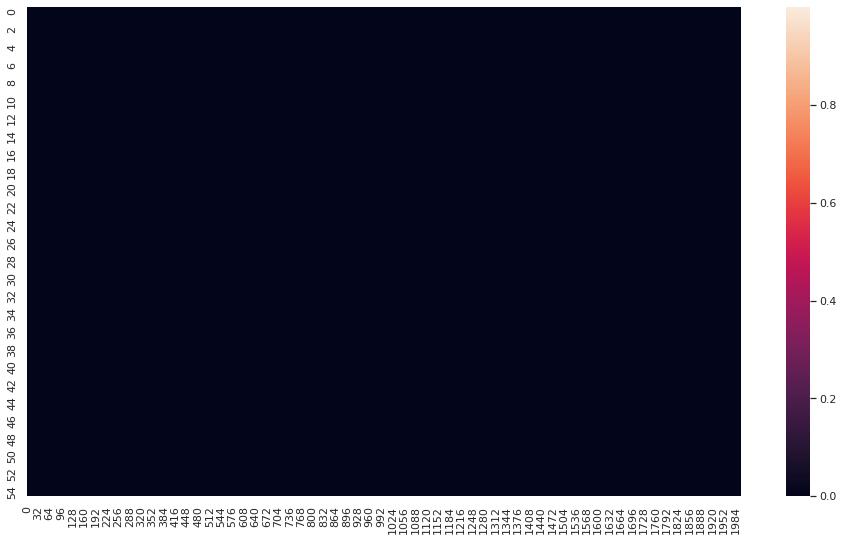

In [ ]:
idx = 1

with torch.no_grad():
    model.eval()
    hidden_states_wav = model.wav2vec2(audio_feature_batch.to(device)).last_hidden_state
    hidden_states_wav = model.compressor(hidden_states_wav.transpose(1,2)).transpose(1,2)
    # hidden_states_wav = model.attn(hidden_states_wav)
        
    sns.heatmap(
        nn.functional.softmax(model.lm_head(hidden_states_wav), dim=2).cpu()[idx,:55, :2000]
    )
    

IPython.display.Audio(dataset['audio_array'][batch_idx[idx]], rate=16000)

In [ ]:
##### val example


device = 'cuda:0'
batch_idx = train_idx

BATCH_SIZE = 16
i = 3

wer_, rouge_r, rouge_p, rouge_f = 0., 0., 0., 0.
for i in tqdm(range(len(val_idx)//BATCH_SIZE + 1)):
    
    batch_idx = val_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
    
    audio_feature_batch = list()
    for idx in batch_idx:
        audio_feature_batch.append(dataset['audio_array'][idx])
    audio_feature_batch = torch.stack(audio_feature_batch)

    label_batch = dataset['text']['input_ids'][batch_idx]
    attention_batch = dataset['text']['attention_mask'][batch_idx]

    with torch.no_grad():
        model.eval()
        pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
        pred_ids = pred_logits.argmax(dim=-1)

        ### only distinct ones
        pred_ids = [[key for key, _group in groupby(i)] for i in pred_ids]

        ### all unnecessary tokens are removed
        label_str = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
        pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

        # rouge_output = rouge.compute(predictions=pred_str, references=label_str, 
        #                                rouge_types=["rouge2"])['rouge2'].mid
        wer_score = wer.compute(predictions=pred_str, references=label_str)
        rouge_score = rouge.evaluate(hypotheses=pred_str, 
                                     multi_references=[[ref] for ref in label_str])['rouge-2']

        wer_ += wer_score * len(batch_idx)
        rouge_r += rouge_score['r'] * len(batch_idx)
        rouge_p += rouge_score['p'] * len(batch_idx)
        rouge_f += rouge_score['f'] * len(batch_idx)
        
print(wer_ / len(val_idx))
print(rouge_r / len(val_idx))
print(rouge_p / len(val_idx))
print(rouge_f / len(val_idx))

100%|██████████| 276/276 [00:23<00:00, 11.53it/s]

0.015221512669100821
0.9814861835944378
0.9827490974328679
0.9821130865308724


In [ ]:
##### train example


device = 'cuda:0'
batch_idx = train_idx

BATCH_SIZE = 16
i = 3

wer_, rouge_r, rouge_p, rouge_f = 0., 0., 0., 0.
for i in tqdm(range(len(train_idx)//BATCH_SIZE + 1)):
    
    batch_idx = train_idx[i*BATCH_SIZE:i*BATCH_SIZE+BATCH_SIZE]
    
    audio_feature_batch = list()
    for idx in batch_idx:
        audio_feature_batch.append(dataset['audio_array'][idx])
    audio_feature_batch = torch.stack(audio_feature_batch)

    label_batch = dataset['text']['input_ids'][batch_idx]
    attention_batch = dataset['text']['attention_mask'][batch_idx]

    with torch.no_grad():
        model.eval()
        pred_logits = model(input_values=audio_feature_batch.to(device), ).logits
        pred_ids = pred_logits.argmax(dim=-1)

        ### only distinct ones
        pred_ids = [[key for key, _group in groupby(i)] for i in pred_ids]

        ### all unnecessary tokens are removed
        label_str = tokenizer.batch_decode(label_batch, skip_special_tokens=True)
        pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)

        # rouge_output = rouge.compute(predictions=pred_str, references=label_str, 
        #                                rouge_types=["rouge2"])['rouge2'].mid
        wer_score = wer.compute(predictions=pred_str, references=label_str)
        rouge_score = rouge.evaluate(hypotheses=pred_str, 
                                     multi_references=[[ref] for ref in label_str])['rouge-2']

        wer_ += wer_score * len(batch_idx)
        rouge_r += rouge_score['r'] * len(batch_idx)
        rouge_p += rouge_score['p'] * len(batch_idx)
        rouge_f += rouge_score['f'] * len(batch_idx)
        
print(wer_ / len(train_idx))
print(rouge_r / len(train_idx))
print(rouge_p / len(train_idx))
print(rouge_f / len(train_idx))

100%|██████████| 2755/2755 [03:59<00:00, 11.49it/s]

0.014801142546488398
0.9824422554168267
0.9837132491871687
0.98307316104721
